<a href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/content/google_colab/cpu_bert_sentiment_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### 2020 George Mihaila.

# GPUs in Natural Language Processing


<td>
    <a target="_blank" href="https://colab.research.google.com/github/gmihaila/gtc2020_instructor_training/blob/master/content/bert_sentiment_clustering.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/gtc2020_instructor_training.git"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Use Sentence Embeddings from pretrained state of the art language models, in this case **bert-base-nli-stsb-mean-tokens**, to transform text data data into fixed vector feratures of length **768 features**. Performing model inference using GPU.
 * Train small Neural Network and interpret model.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

In [1]:
# install sentence transfomers
!pip install git+https://github.com/arvkevi/kneed --quiet # for graph knee detection
!pip install git+https://github.com/UKPLab/sentence-transformers --quiet
!pip install lime --quiet

## Downloads

* **data/imdb_reviews_50k.csv** contains all movie revies and their sentiments:
    
* **data/movies_reviews_embeddings_part1.npy** and **data/movies_reviews_embeddings_part2.npy** contain BERT Embeddings of all `50,000` movie revies. They are saved in numpy format binary. 
   They are the output of running `SentenceTransformer` on all the text using `bert-base-nli-mean-tokens` pretrained model.

In [2]:
import os
if not os.path.exists('imdb_reviews_50k.csv'):
  # IMDB movie reviews
  !wget https://raw.githubusercontent.com/gmihaila/gtc2020_instructor_training/master/data/imdb_reviews_50k.csv --quiet

if not os.path.exists('imdb_reviews_subwords8k_text_features.pickle'):
  # IMDB reviews text features
  !wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/imdb_reviews_subwords8k_text_features.pickle --quiet

if not os.path.exists('movies_reviews_embeddings_part1.npy'):
  # IMDB reviews text features
  !wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/movies_reviews_embeddings_part1.npy --quiet

if not os.path.exists('movies_reviews_embeddings_part2.npy'):
  # IMDB reviews text features
  !wget https://github.com/gmihaila/gtc2020_instructor_training/raw/master/data/movies_reviews_embeddings_part2.npy --quiet
!ls

imdb_reviews_50k.csv
imdb_reviews_subwords8k_text_features.pickle
movies_reviews_embeddings_part1.npy
movies_reviews_embeddings_part2.npy
sample_data


## Imports

In [3]:
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from lime.lime_text import LimeTextExplainer


nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

PRETRAINED_MODEL = 'bert-base-nli-stsb-mean-tokens'

TensorFlow 2.x selected.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Functions

In [0]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Data Prep

## Read CSV

In [5]:
# read reviews from csv file
review_sentiments_df = pd.read_csv('imdb_reviews_50k.csv')
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['review'].values, review_sentiments_df['sentiment'].values
# print first 2 examples
review_sentiments_df.head(n=2)

,review,sentiment
0,"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",0
1,"I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.",0


## BERT Embeddings

In [6]:
# load for future predicitons
embedding_model = SentenceTransformer(model_name_or_path='bert-base-nli-mean-tokens',
                                    device=torch.device('cpu'))
# load embeddings for all reviews
reviews_embeddings_part1 = np.load('movies_reviews_embeddings_part1.npy')
reviews_embeddings_part2 = np.load('movies_reviews_embeddings_part2.npy')
# concatenate parts
reviews_embeddings = np.concatenate((reviews_embeddings_part1, reviews_embeddings_part2))

print('Bert Embeddings Loaded: ', reviews_embeddings.shape)

Bert Embeddings Loaded:  (50000, 768)


# Simple Neural Network

## Config

In [0]:
EMBEDDING_SIZE = 768
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [8]:
# split train 80% - test 20% 
embeddings_train, embeddings_test, sentiments_train, sentiments_test = train_test_split(reviews_embeddings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
embeddings_train, embeddings_valid, sentiments_train, sentiments_valid = train_test_split(embeddings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', embeddings_train.shape)
print('Validation shape:', embeddings_valid.shape)
print('Test shape:      ', embeddings_test.shape)

Train shape:      (36000, 768)
Validation shape: (4000, 768)
Test shape:       (10000, 768)


## Data Generators

In [0]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((embeddings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((embeddings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 16)                12304     
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________
Train for 72 steps, validate for 8 steps
Epoch 1/20
72/72 [==============================] - 1s 13ms/step - loss: 0.4712 - accuracy: 0.7710 - val_loss: 0.4242 - val_accuracy: 0.7995
Epoch 2/20
72/72 [==============================] - 1s 8ms/step - loss: 0.4208 - accuracy: 0.8046 - val_loss: 0.4098 - val_accuracy: 0.8095
Epoch 3/20
72/72 [==============================] - 1s 7ms/step - loss: 0.4063 - accuracy: 0.8141 - val_loss: 0.4004 - val_accuracy: 0.8198
Epoch 4/20
72/72 [==============================] - 

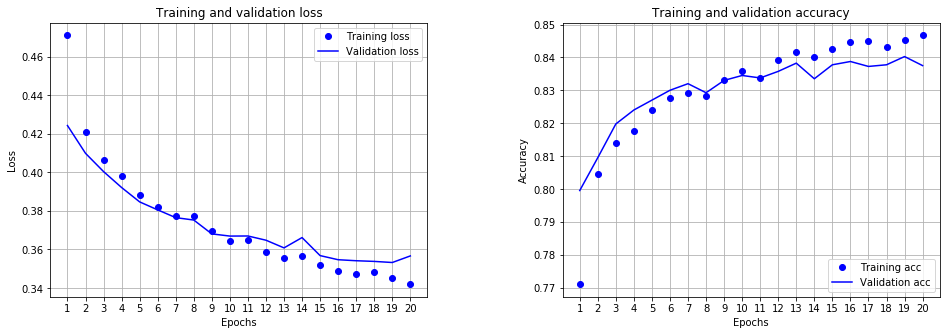

In [10]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(16, input_shape=(EMBEDDING_SIZE,), activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)
# plot training curves
plt_history(history_dict=history.history)

## Evaluation

In [11]:
# get model predicitons
sentiments_predicitons = model.predict_classes(embeddings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      4948
           1       0.85      0.79      0.82      5052

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



## Explain Model

In [0]:
example_sample = 'This movie was great! I loved it!'

# explain model prediciton
def classifier_dn(texts):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  encodings_texts = embedding_model.encode(sentences=texts, 
                                          batch_size=500, 
                                          show_progress_bar=True)
  encodings_texts = np.array(encodings_texts)
  for encoding_text in encodings_texts:
    preds = model(encoding_text.reshape(1,768))[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(example_sample,  classifier_dn, num_features=EMBEDDING_SIZE)
# output to cell
exp.show_in_notebook(text=True)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
Batches:  70%|███████   | 7/10 [01:15<00:35, 11.74s/it]

# Find Best K-means

In [0]:
# maximum number of clusters to use
max_n_cluster = 10

## Elbow Method
* Distortion is defined as the sum of the squared distances between each observation vector and its dominating centroid.
* Find out more about [inertia/distortion](https://scikit-learn.org/stable/modules/clustering.html#k-means)

In [0]:
def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  # list of clusters
  clusters = list(range(2, n_clusters))
  # store all distortions
  distortions = []
  # apply kmeans for each cluster values
  for n_clusters in clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    # get distortions
    distortion = kmean_model.inertia_
    distortions.append(distortion)
    # print output
    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)
  # locate knee
  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)
  # plot
  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
  fig.savefig("elbow_distortions.png")
  return

# run function
best_kmeans_elbow(features=reviews_embeddings, 
                  n_clusters=max_n_cluster, 
                  verbose=True)

## Silhouette Method [time consuming]

* The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

In [0]:
def best_kmeans_silhouette(features, n_clusters):
  # get list of clusters  
  clusters = list(range(2, n_clusters))
  # store all silhouttes values
  silhouettes = []
  # run k-means for each cluter
  for n_clusters in clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))
    # get labels predicted
    cluster_labels = kmean_model.predict(features)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
  # find best k
  best_k = clusters[silhouettes.index(max(silhouettes))]
  # plot
  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
  fig.savefig("silhouette_avg.png")
  return

# run fucntion
best_kmeans_silhouette(features=reviews_embeddings, 
                       n_clusters=max_n_cluster)

# Run Best k-means model

In [0]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

In [0]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
    cluster_plot.savefig("pca_plot.png")
  return reduced_features

In [0]:
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [0]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [0]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

In [0]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [0]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

## k=4 sentiments

In [0]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [0]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

In [0]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), 
                    magnify=3)

### Visualize

In [0]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [0]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

# Custom Samples

In [0]:
custom_text = "This workshop roks!!"

encodings_texts = embedding_model.encode(sentences=[custom_text], 
                                          batch_size=1, 
                                          show_progress_bar=True)
encodings_texts = np.array(encodings_texts)
kmean_label = kmean_model.predict(tf.get_static_value(encodings_texts))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])